In [44]:
import glob
import os
import warnings
import mlflow
import mlflow.pytorch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from pydicom.data import get_testdata_files
from sklearn.model_selection import train_test_split
from torchvision import transforms
from IPython.display import Markdown, display

 # Import functions from the module
import importlib
import help_files._0_definitions 
import  help_files._1_visuals_script
# import  help_files._01_load_data
 # Reload the module to apply the changes to the script
importlib.reload(help_files._0_definitions)
importlib.reload(help_files._1_visuals_script)
# importlib.reload(help_files._01_load_data)
import  help_files._1_visuals_script  as pauls_vs
# Group by 'condition', 'level', and 'severity' and count occurrences
from help_files._0_definitions import count_severity_by_condition_level 
# Define the path
from pathlib import Path

pd.set_option("display.width", 1000)  # Set a large width to prevent line wrapping
 

In [45]:
### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_definitions.py") as file:
    exec(file.read())
    ### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_run_definitions.py") as file:
    exec(file.read())

In [46]:
# loading data
file_names = ["train_df_3_cat.csv", "test_df_3_cat.csv"]
# Load the data from the CSV files
dataframes = [pd.read_csv(data_path_vor / file_name) for file_name in file_names]
# Unpack the dataframes into separate variables
train_df, test_df = dataframes

print("DataFrames have been loaded successfully.")


DataFrames have been loaded successfully.


In [47]:
# Defining small sample vs. end smaple
whole_data_set = False
# end sample or small sample    
if whole_data_set == True:
    print("Using the whole data set")
else:
    train_df = train_df.sample(n=3, random_state=RSEED)
    test_df = test_df.sample(n=6, random_state=RSEED)
    display(Markdown('<span style="color:red"> this is a small sample : 48692</span>'))

<span style="color:red"> this is a small sample : 48692</span>

new code l

In [48]:
train_df

,study_id,severity,condition,level,series_id,x,y,image_path,missing_image
1935,684747623,2.0,0,l5/s1,3.273038e+09,370.053272,506.149133,data/train_images_origin/684747623/774494956/7...,False
6494,2325650566,1.0,0,l5/s1,2.076691e+09,293.720819,472.222032,data/train_images_origin/2325650566/20477869/5...,False
1720,624881903,2.0,0,l5/s1,1.233162e+09,375.776524,475.359848,data/train_images_origin/624881903/1233161684/...,False


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from PIL import Image
import pydicom
import torch.nn.functional as F

# Define U-Net model with reduced complexity
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsampling (Encoder) with reduced filter sizes
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Upsampling (Decoder)
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = self.upconv_block(256, 128)
        self.up2 = self.upconv_block(128, 64)
        self.up1 = self.upconv_block(64, 32)

        # Final convolution for regression
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decoder path with upsampling and skip connections
        up4 = F.interpolate(self.up4(bottleneck), size=enc4.shape[2:]) + enc4
        up3 = F.interpolate(self.up3(up4), size=enc3.shape[2:]) + enc3
        up2 = F.interpolate(self.up2(up3), size=enc2.shape[2:]) + enc2
        up1 = F.interpolate(self.up1(up2), size=enc1.shape[2:]) + enc1

        # Final output
        output = self.final_conv(up1)
        output = F.adaptive_avg_pool2d(output, (1, 1))  # Reduce spatial dimensions
        output = output.view(output.size(0), -1)  # Reshape to [batch_size, 2]
        return output

# Custom dataset for MRI localization
class MRILocalizationDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        try:
            dicom_image = pydicom.dcmread(img_path)
            image_array = dicom_image.pixel_array
        except Exception as e:
            print(f"Failed to load DICOM file at {img_path}: {e}")
            return None

        image = Image.fromarray(image_array)
        # Convert grayscale to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        x = torch.tensor(self.data.iloc[idx]['x'], dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx]['y'], dtype=torch.float32)

        return image, torch.tensor([x, y])

# Data transformations (smaller image size of 128x128)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# DataLoader setup
dataset = MRILocalizationDataset(data=train_df, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=2)
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set experiment in MLflow
experiment_name = "MRI_Localization_UNet"
mlflow.set_experiment(experiment_name)

# Define an input example for MLflow
input_example = torch.randn(1, 3, 224, 224, device=device)  # Random tensor simulating one sample image
import os
import torch
import mlflow
import matplotlib.pyplot as plt

# Initialize early stopping parameters
best_val_loss = float('inf')
patience_counter = 0
patience = 5  # Number of epochs to wait for improvement before stopping
diverge_count = 0
max_diverge_count = 3  # Number of times validation loss can diverge before stopping
stop_threshold = 0.1  # Threshold for validation loss divergence

with mlflow.start_run():
    # Log experiment parameters
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("model_architecture", "U-Net for Localization")
    mlflow.log_param("output_coordinates", "x, y")

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            if inputs is None or targets is None:
                continue

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        mlflow.log_metric("train_loss", train_loss, step=epoch)

        # Validation loss calculation (this should happen after training)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                if inputs is None or targets is None:
                    continue
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        mlflow.log_metric("val_loss", val_loss, step=epoch)

        # Check if validation loss improves and save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter if validation loss improves
            best_model_path = f"best_model_weights_epoch_{epoch + 1}.pt"
            torch.save(model.state_dict(), best_model_path)
            mlflow.log_artifact(best_model_path)  # Log the best model weights
            os.remove(best_model_path)  # Optionally, delete the local file after logging
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} due to lack of validation loss improvement.")
                break

        # Early stopping based on validation loss divergence (optional)
        if val_loss > best_val_loss * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch + 1} due to validation loss divergence.")
                break
        else:
            diverge_count = 0  # Reset diverge count if validation loss doesn't diverge


        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}')            

        # Log metrics at each epoch
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)

    # Log the final model
    input_example_np = input_example.cpu().numpy()  # Convert tensor to numpy array
    mlflow.pytorch.log_model(model, "final_model", input_example=input_example_np)


    # Plot and save the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig("loss_curve.png")
    mlflow.log_artifact("loss_curve.png")


In [49]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from PIL import Image
import pydicom
import torch.nn.functional as F

# Define U-Net model with reduced complexity
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsampling (Encoder) with reduced filter sizes
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Upsampling (Decoder)
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = self.upconv_block(256, 128)
        self.up2 = self.upconv_block(128, 64)
        self.up1 = self.upconv_block(64, 32)

        # Final convolution for regression
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decoder path with upsampling and skip connections
        up4 = F.interpolate(self.up4(bottleneck), size=enc4.shape[2:]) + enc4
        up3 = F.interpolate(self.up3(up4), size=enc3.shape[2:]) + enc3
        up2 = F.interpolate(self.up2(up3), size=enc2.shape[2:]) + enc2
        up1 = F.interpolate(self.up1(up2), size=enc1.shape[2:]) + enc1

        # Final output
        output = self.final_conv(up1)
        output = F.adaptive_avg_pool2d(output, (1, 1))  # Reduce spatial dimensions
        output = output.view(output.size(0), -1)  # Reshape to [batch_size, 2]
        return output

# Custom dataset for MRI localization
class MRILocalizationDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        try:
            dicom_image = pydicom.dcmread(img_path)
            image_array = dicom_image.pixel_array
        except Exception as e:
            print(f"Failed to load DICOM file at {img_path}: {e}")
            return None

        image = Image.fromarray(image_array)
        # Convert grayscale to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        x = torch.tensor(self.data.iloc[idx]['x'], dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx]['y'], dtype=torch.float32)

        return image, torch.tensor([x, y])

# Data transformations (smaller image size of 128x128)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Hyperparameters
learning_rate = 0.001
batch_size = 8
num_epochs =3

# DataLoader setup
dataset = MRILocalizationDataset(data=train_df, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 18
num_epochs = 2
learning_rate = 0.0001

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=2)
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set experiment in MLflow
experiment_name = "MRI_Localization_UNet"
mlflow.set_experiment(experiment_name)

# Define an input example for MLflow
input_example = torch.randn(1, 3, 224, 224, device=device)  # Random tensor simulating one sample image


In [11]:
#  6 minutes×30=180 minutes(or 3 hours per epoch für 100 )
print(0.001 * 1000)


1.0


2024/11/12 20:17:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


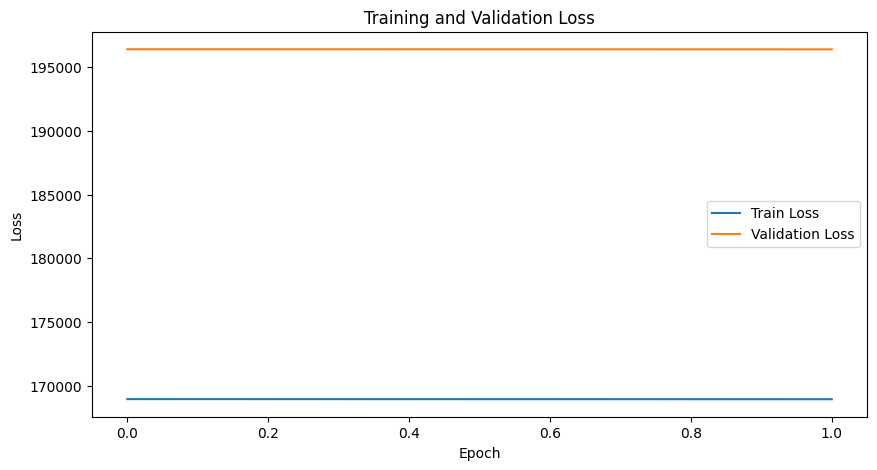

In [51]:
import os
import torch
import mlflow
import matplotlib.pyplot as plt

# Initialize early stopping parameters
best_val_loss = float('inf')
patience_counter = 0
patience = 5  # Number of epochs to wait for improvement before stopping
diverge_count = 0
max_diverge_count = 3  # Number of times validation loss can diverge before stopping
stop_threshold = 0.1  # Threshold for validation loss divergence

with mlflow.start_run():
    # Log experiment parameters
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("model_architecture", "U-Net for Localization")
    mlflow.log_param("output_coordinates", "x, y")

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            if inputs is None or targets is None:
                continue

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        mlflow.log_metric("train_loss", train_loss, step=epoch)

        # Validation loss calculation (this should happen after training)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                if inputs is None or targets is None:
                    continue
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        mlflow.log_metric("val_loss", val_loss, step=epoch)

        # Check if validation loss improves and save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter if validation loss improves
            best_model_path = f"best_model_weights_epoch_{epoch + 1}.pt"
            torch.save(model.state_dict(), best_model_path)
            mlflow.log_artifact(best_model_path)  # Log the best model weights
            os.remove(best_model_path)  # Optionally, delete the local file after logging
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} due to lack of validation loss improvement.")
                break

        # Early stopping based on validation loss divergence (optional)
        if val_loss > best_val_loss * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch + 1} due to validation loss divergence.")
                break
        else:
            diverge_count = 0  # Reset diverge count if validation loss doesn't diverge

        # Log metrics at each epoch
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)

    # Save the final model
    mlflow.pytorch.log_model(model, "final_model")

    # Plot and save the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig("loss_curve.png")
    mlflow.log_artifact("loss_curve.png")


In [26]:
ss

NameError: name 'ss' is not defined

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import pydicom
import torch.nn.functional as F

# Define U-Net model with reduced complexity
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsampling (Encoder) with reduced filter sizes
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Upsampling (Decoder)
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = self.upconv_block(256, 128)
        self.up2 = self.upconv_block(128, 64)
        self.up1 = self.upconv_block(64, 32)

        # Final convolution for regression
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decoder path with upsampling and skip connections
        up4 = F.interpolate(self.up4(bottleneck), size=enc4.shape[2:]) + enc4
        up3 = F.interpolate(self.up3(up4), size=enc3.shape[2:]) + enc3
        up2 = F.interpolate(self.up2(up3), size=enc2.shape[2:]) + enc2
        up1 = F.interpolate(self.up1(up2), size=enc1.shape[2:]) + enc1

        # Final output
        output = self.final_conv(up1)
        output = F.adaptive_avg_pool2d(output, (1, 1))  # Reduce spatial dimensions
        output = output.view(output.size(0), -1)  # Reshape to [batch_size, 2]
        return output

# Custom dataset for MRI localization
class MRILocalizationDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        try:
            dicom_image = pydicom.dcmread(img_path)
            image_array = dicom_image.pixel_array
        except Exception as e:
            print(f"Failed to load DICOM file at {img_path}: {e}")
            return None

        image = Image.fromarray(image_array)
        # Convert grayscale to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        x = torch.tensor(self.data.iloc[idx]['x'], dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx]['y'], dtype=torch.float32)

        return image, torch.tensor([x, y])

# Data transformations (smaller image size of 128x128)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Hyperparameters
learning_rate = 1e-4
batch_size = 8
num_epochs = 5

# DataLoader setup
train_dataset = MRILocalizationDataset(data=train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Model initialization
model = UNet(in_channels=3, out_channels=2)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set experiment in MLflow
experiment_name = "MRI_Localization_UNet"
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    # Log experiment parameters
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("model_architecture", "U-Net for Localization")
    mlflow.log_param("output_coordinates", "x, y")

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            if inputs is None or targets is None:
                continue

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    # Save


testing a new model

In [ ]:
# Inference with disabled gradient tracking
model.eval()
with torch.no_grad():
    test_image = Image.open("path_to_new_image.dcm")
    test_image = transform(test_image).unsqueeze(0)  # Add batch dimension
    predicted_coords = model(test_image)
    print(f"Predicted x, y coordinates: {predicted_coords}")

In [24]:
ss

NameError: name 'ss' is not defined

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from PIL import Image
import pydicom
import torch.nn.functional as F

# Define U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsampling (Encoder)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Upsampling (Decoder)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.up3 = self.upconv_block(512, 256)
        self.up2 = self.upconv_block(256, 128)
        self.up1 = self.upconv_block(128, 64)



        # Final convolution for regression
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)  # Now outputs 2 values (x, y)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        print(f"enc1 shape: {enc1.shape}")
        enc2 = self.enc2(enc1)
        print(f"enc2 shape: {enc2.shape}")
        enc3 = self.enc3(enc2)
        print(f"enc3 shape: {enc3.shape}")
        enc4 = self.enc4(enc3)
        print(f"enc4 shape: {enc4.shape}")
        
        # Bottleneck
        bottleneck = self.bottleneck(enc4)
        print(f"bottleneck shape: {bottleneck.shape}")

        # Decoder path with upsampling and skip connections
        up4 = self.up4(bottleneck)
        print(f"up4 (before interpolation) shape: {up4.shape}")
        up4 = F.interpolate(up4, size=enc4.shape[2:])  # Resize up4 to match enc4
        print(f"up4 (after interpolation) shape: {up4.shape}")
        up4 = up4 + enc4  # Skip connection
        print(f"up4 (after addition with enc4) shape: {up4.shape}")

        up3 = self.up3(up4)
        print(f"up3 (before interpolation) shape: {up3.shape}")
        up3 = F.interpolate(up3, size=enc3.shape[2:])  # Resize to match enc3
        print(f"up3 (after interpolation) shape: {up3.shape}")
        up3 = up3 + enc3  # Skip connection
        print(f"up3 (after addition with enc3) shape: {up3.shape}")

        up2 = self.up2(up3)
        print(f"up2 (before interpolation) shape: {up2.shape}")
        up2 = F.interpolate(up2, size=enc2.shape[2:])  # Resize to match enc2
        print(f"up2 (after interpolation) shape: {up2.shape}")
        up2 = up2 + enc2  # Skip connection
        print(f"up2 (after addition with enc2) shape: {up2.shape}")

        up1 = self.up1(up2)
        print(f"up1 (before interpolation) shape: {up1.shape}")
        up1 = F.interpolate(up1, size=enc1.shape[2:])  # Resize to match enc1
        print(f"up1 (after interpolation) shape: {up1.shape}")
        up1 = up1 + enc1  # Skip connection
        print(f"up1 (after addition with enc1) shape: {up1.shape}")

        # Final output
        output = self.final_conv(up1)

        # Global average pooling to reduce spatial dimensions for coordinate regression
        output = F.adaptive_avg_pool2d(output, (1, 1))  # output shape: [batch_size, 2, 1, 1]
        output = output.view(output.size(0), -1)  # Reshape to [batch_size, 2]
        print(f"output shape: {output.shape}")
        return output


# Custom dataset for MRI localization
class MRILocalizationDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        dicom_image = pydicom.dcmread(img_path)
        image_array = dicom_image.pixel_array
        image = Image.fromarray(image_array)

        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Extract x and y coordinates for localization
        x = torch.tensor(self.data.iloc[idx]['x'], dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx]['y'], dtype=torch.float32)

        return image, torch.tensor([x, y]) 

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Assuming 'df' is a pandas DataFrame containing MRI data
train_dataset = MRILocalizationDataset(data=train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Model initialization
model = UNet(in_channels=3, out_channels=2)  # 3 channels for RGB, 2 for x and y coordinates

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for coordinate regression
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Save model with MLflow
with mlflow.start_run():
    mlflow.pytorch.log_model(model, "model")
    mlflow.log_params({"epochs": epochs, "batch_size": 4, "learning_rate": 1e-4})

# Inference (predicting x, y coordinates for new test images)
model.eval()
with torch.no_grad():
    test_image = Image.open("path_to_new_image.dcm")
    test_image = transform(test_image).unsqueeze(0)  # Add batch dimension
    predicted_coords = model(test_image)
    print(f"Predicted x, y coordinates: {predicted_coords}")


In [ ]:
sssss

Calss definition dataloader (do not change over models)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from PIL import Image
import pydicom

# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(UNet, self).__init__()

        # Encoding path (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.center = self.conv_block(512, 1024)

        # Decoding path (upsampling)
        self.upconv4 = self.upconv_block(1024 + 512, 512)  # Concatenate 1024 + 512
        self.upconv3 = self.upconv_block(512 + 256, 256)   # Concatenate 512 + 256
        self.upconv2 = self.upconv_block(256 + 128, 128)   # Concatenate 256 + 128
        self.upconv1 = self.upconv_block(128 + 64, 64)     # Concatenate 128 + 64

        # Final convolution to match the output size
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        # Use F.interpolate for resizing to the correct size
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),  # Reduce channels
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        center = self.center(F.max_pool2d(enc4, 2))

        # Decoding path (upsampling)
        up4 = self.upconv4(torch.cat([center, enc4], 1))  # Concatenating with enc4
        up4 = F.interpolate(up4, size=enc4.shape[2:], mode='bilinear', align_corners=False)
        up3 = self.upconv3(torch.cat([up4, enc3], 1))  # Concatenating with enc3
        up3 = F.interpolate(up3, size=enc3.shape[2:], mode='bilinear', align_corners=False)
        up2 = self.upconv2(torch.cat([up3, enc2], 1))  # Concatenating with enc2
        up2 = F.interpolate(up2, size=enc2.shape[2:], mode='bilinear', align_corners=False)
        up1 = self.upconv1(torch.cat([up2, enc1], 1))  # Concatenating with enc1
        up1 = F.interpolate(up1, size=enc1.shape[2:], mode='bilinear', align_corners=False)

        # Final output
        out = self.final_conv(up1)

        return out

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
dataset = MRILocalizationDataset(data=train_df, transform=transform)

# Train-test split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloader
batch_size = 16
num_epochs = 10
learning_rate = 0.001
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=2)  # For x and y coordinates
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# MLflow setup
experiment_name = "MRI_Localization_UNet"
mlflow.set_experiment(experiment_name)

# Initialize early stopping parameters
stop_threshold = 0.4
max_diverge_count = 3
patience = 5
best_val_loss = float('inf')
diverge_count = 0
patience_counter = 0

# Training loop with early stopping
with mlflow.start_run():
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("model_architecture", "U-Net for Localization")
    mlflow.log_param("output_coordinates", "x, y")

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs): 
        model.train()
        train_loss = 0.0

        for images, coordinates in train_loader:
            images, coordinates = images.to(device), coordinates.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            # Flatten the output tensor to match the target shape (batch_size, 2)
            outputs = outputs.view(outputs.size(0), -1)

            # Ensure the shape of outputs matches the target (x, y)
            if outputs.size(1) != 2:
                outputs = outputs[:, :2]  # Only take the first 2 channels if the output size is incorrect

            loss = criterion(outputs, coordinates)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        mlflow.log_metric("train_loss", train_loss, step=epoch)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, coordinates in val_loader:
                images, coordinates = images.to(device), coordinates.to(device)
                outputs = model(images)

                # Flatten the output tensor to match the target shape (batch_size, 2)
                outputs = outputs.view(outputs.size(0), -1)
                if outputs.size(1) != 2:
                    outputs = outputs[:, :2]

                loss = criterion(outputs, coordinates)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        mlflow.log_metric("val_loss", val_loss, step=epoch)

        # Check if validation loss improves and save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter if validation loss improves
            best_model_path = f"best_model_weights_epoch_{epoch + 1}.pt"
            torch.save(model.state_dict(), best_model_path)
            mlflow.log_artifact(best_model_path)  # Log the best model weights
            os.remove(best_model_path)  # Optionally, delete the local file after logging

        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} due to lack of validation loss improvement.")
                break

        # Early stopping based on validation loss divergence (optional)
        if val_loss > best_val_loss * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch + 1} due to validation loss divergence.")
                break
        else:
            diverge_count = 0  # Reset diverge count if validation loss doesn't diverge

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}')

        # Save model at each epoch (optional)
        epoch_model_path = f"model_epoch_{epoch + 1}.pt"
        torch.save(model.state_dict(), epoch_model_path)
        mlflow.log_artifact(epoch_model_path)  # Log the model weights at each epoch
        os.remove(epoch_model_path)  # Optionally, delete the local file after logging

    # Plot and save loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig("loss_curve.png")
    mlflow.log_artifact("loss_curve.png")


In [ ]:
s

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from PIL import Image
import pydicom

# Define U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Downsampling (Encoder)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Upsampling (Decoder)
        self.up4 = self.upconv_block(1024, 512)
        self.up3 = self.upconv_block(512, 256)
        self.up2 = self.upconv_block(256, 128)
        self.up1 = self.upconv_block(128, 64)
        
        # Final convolution
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Downsampling
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc4)
        
        # Upsampling
        up4 = self.up4(bottleneck)
        up4 = up4 + enc4  # Skip connection
        up3 = self.up3(up4)
        up3 = up3 + enc3  # Skip connection
        up2 = self.up2(up3)
        up2 = up2 + enc2  # Skip connection
        up1 = self.up1(up2)
        up1 = up1 + enc1  # Skip connection
        
        # Final output layer
        output = self.final_conv(up1)
        
        return output

# Custom dataset for MRI localization
class MRILocalizationDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        dicom_image = pydicom.dcmread(img_path)
        image_array = dicom_image.pixel_array
        image = Image.fromarray(image_array)

        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Extract x and y coordinates for localization
        x = torch.tensor(self.data.iloc[idx]['x'], dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx]['y'], dtype=torch.float32)

        return image, torch.tensor([x, y]) 

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Assuming 'df' is a pandas DataFrame containing MRI data
train_dataset = MRILocalizationDataset(data=df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Model initialization
model = UNet(in_channels=3, out_channels=2)  # 3 channels for RGB, 2 for x and y coordinates

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for coordinate regression
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Save model with MLflow
with mlflow.start_run():
    mlflow.pytorch.log_model(model, "model")
    mlflow.log_params({"epochs": epochs, "batch_size": 4, "learning_rate": 1e-4})

# Inference (predicting x, y coordinates for new test images)
model.eval()
with torch.no_grad():
    test_image = Image.open("path_to_new_image.dcm")
    test_image = transform(test_image).unsqueeze(0)  # Add batch dimension
    predicted_coords = model(test_image)
    print(f"Predicted x, y coordinates: {predicted_coords}")


In [ ]:
sssss

Step 1: U-Net Model and Data Preparation

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from PIL import Image
import pydicom

# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Downsampling (Encoder)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Upsampling (Decoder)
        self.up4 = self.upconv_block(1024, 512)
        self.up3 = self.upconv_block(512, 256)
        self.up2 = self.upconv_block(256, 128)
        self.up1 = self.upconv_block(128, 64)
        
        # Final convolution
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Downsampling
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc4)
        
        # Upsampling
        up4 = self.up4(bottleneck)
        up4 = up4 + enc4  # Skip connection
        up3 = self.up3(up4)
        up3 = up3 + enc3  # Skip connection
        up2 = self.up2(up3)
        up2 = up2 + enc2  # Skip connection
        up1 = self.up1(up2)
        up1 = up1 + enc1  # Skip connection
        
        # Final output layer
        output = self.final_conv(up1)
        
        return output

# Dataset class for MRI Localization
class MRILocalizationDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        dicom_image = pydicom.dcmread(img_path)
        image_array = dicom_image.pixel_array
        image = Image.fromarray(image_array)

        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        x = torch.tensor(self.data.iloc[idx]['x'], dtype=torch.float32)
        y = torch.tensor(self.data.iloc[idx]['y'], dtype=torch.float32)

        return image, torch.tensor([x, y])

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
dataset = MRILocalizationDataset(data=train_df, transform=transform)

# Train-test split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloader
batch_size = 16
num_epochs = 10
learning_rate = 0.0001
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=2)  # For x and y coordinates
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# MLflow setup
experiment_name = "MRI_Localization_UNet"
mlflow.set_experiment(experiment_name)

# Initialize early stopping parameters
stop_threshold = 0.4
max_diverge_count = 3
patience = 5
best_val_loss = float('inf')
diverge_count = 0
patience_counter = 0

# Training loop with early stopping
with mlflow.start_run():
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("model_architecture", "U-Net for Localization")
    mlflow.log_param("output_coordinates", "x, y")

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs): 
        model.train()
        train_loss = 0.0

        for images, coordinates in train_loader:
            images, coordinates = images.to(device), coordinates.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            # Flatten the output tensor to match the target shape (batch_size, 2)
            outputs = outputs.view(outputs.size(0), -1)

            # Ensure the shape of outputs matches the target (x, y)
            if outputs.size(1) != 2:
                outputs = outputs[:, :2]  # Only take the first 2 channels if the output size is incorrect

            loss = criterion(outputs, coordinates)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        mlflow.log_metric("train_loss", train_loss, step=epoch)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, coordinates in val_loader:
                images, coordinates = images.to(device), coordinates.to(device)
                outputs = model(images)

                # Flatten the output tensor to match the target shape (batch_size, 2)
                outputs = outputs.view(outputs.size(0), -1)
                if outputs.size(1) != 2:
                    outputs = outputs[:, :2]

                loss = criterion(outputs, coordinates)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        mlflow.log_metric("val_loss", val_loss, step=epoch)

        # Check if validation loss improves and save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter if validation loss improves
            best_model_path = f"best_model_weights_epoch_{epoch + 1}.pt"
            torch.save(model.state_dict(), best_model_path)
            mlflow.log_artifact(best_model_path)  # Log the best model weights
            os.remove(best_model_path)  # Optionally, delete the local file after logging

        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} due to lack of validation loss improvement.")
                break

        # Early stopping based on validation loss divergence (optional)
        if val_loss > best_val_loss * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch + 1} due to validation loss divergence.")
                break
        else:
            diverge_count = 0  # Reset diverge count if validation loss doesn't diverge

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}')

        # Save model at each epoch (optional)
        epoch_model_path = f"model_epoch_{epoch + 1}.pt"
        torch.save(model.state_dict(), epoch_model_path)
        mlflow.log_artifact(epoch_model_path)  # Log the model weights at each epoch
        os.remove(epoch_model_path)  # Optionally, delete the local file after logging


    # Plot and save loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(50), train_losses, label='Train Loss')
    plt.plot(range(50), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig("loss_curve.png")
    mlflow.log_artifact("loss_curve.png")


In [ ]:
sss

predictions

In [ ]:
train_df

test predicion

In [65]:

test_df = test_df.drop(['severity', 'condition', 'level', 'series_id', 'missing_image'], axis=1)


In [ ]:
print(test_df.to_string(index=False, header=True)) 

predicting

In [ ]:
import numpy as np
import pandas as pd
import torch
import mlflow
from torch.utils.data import DataLoader

# Load the trained model from MLflow
model_path = "C:/Users/HP1/Desktop/Spiced/capstone-project/mlruns/491281383988954356/344ed7741b8b4cb9bf87844ab1e511af/artifacts/final_model"
model = mlflow.pytorch.load_model(model_path)


# Print the entire model architecture
print(model)
for name, layer in model.named_children():
    print(f"Layer name: {name}")
    print(layer)
for name, param in model.named_parameters():
    print(f"Layer: {name} | Shape: {param.shape}")
